# Clustering analysis
Create hierarchical clusters for each emotion based on the different configurations. Then (in `hierarchical_cluster_similarity_analysis.py`), we can check whether how the configurations across the hierarchy affect the similarity across trials.

In [1]:
import numpy as np
import pandas as pd
import os.path as op
from glob import glob
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
import seaborn as sns

def _recursive_clust_lookup(c, Z):

    for i in range(len(c)):
        if c[i] <= Z.shape[0]:
            pass
        else:
            idx = c[i] - (Z.shape[0] + 1)
            to_add = Z[idx, :2].astype(int).tolist()
            c[i] = _recursive_clust_lookup(to_add, Z)

    return c


def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

# indices = []
# for i in range(Z.shape[0]):
#     c1, c2, dist, n_c = Z[i, :]
#     c = [int(c1), int(c2)]
#     c[0] = _recursive_clust_lookup([c[0]], Z)
#     c[1] = _recursive_clust_lookup([c[1]], Z)
#     c = list(flatten(c[0] + c[1]))
#     indices.append(c)
    
# df_clust = []
# for c in indices:
#     df_clust.append(df_emo.iloc[c, :].mean(axis=0).to_frame().T)
    
# df_clust = pd.concat(df_clust, axis=0)
# df_clust = (df_clust > 0.7).astype(int)
# df_clust.sum(axis=1)

In [2]:
tsvs = [f for f in sorted(glob('../data/*.tsv')) if not 'Hierarchical' in f] 
dfs = []
for f in tsvs:
    df = pd.read_csv(f, sep='\t', index_col=0)
    if 'Jack' in f:
        df = df.query("sub == 'average_all' & trial_split == 'all'")
        df = df.drop(['sub', 'trial_split'], axis=1)
    else:
        df = df.reset_index().rename({'index': 'emotion'}, axis=1)
        
    df['mapping'] = op.basename(f).split('.')[0]
    dfs.append(df)
    
df = pd.concat(dfs)

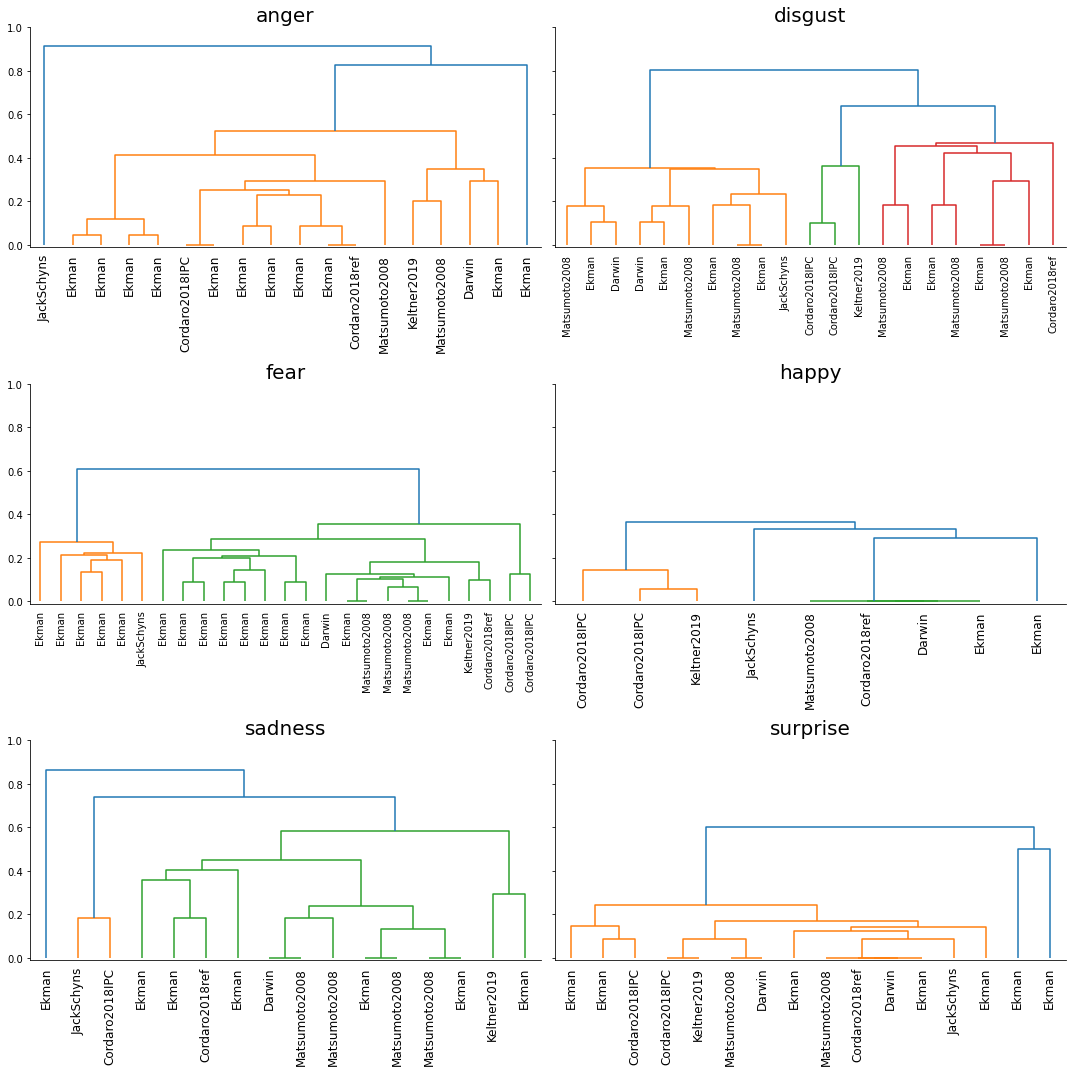

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharey=True, facecolor='white')
df_clust_all = []
for i, emo in enumerate(df['emotion'].unique()):
    df_emo = df.query("emotion == @emo").drop('emotion', axis=1).set_index('mapping')
    Z = linkage(df_emo.to_numpy(), metric='cosine', method='average', optimal_ordering=True)
    ax = axes.flatten()[i]
    dend = dendrogram(Z, ax=ax)
    ax.set_xticklabels(df_emo.index[dend['leaves']].to_list(), rotation=90)
    ax.set_title(emo, fontsize=20)

    indices = []
    for i in range(Z.shape[0]):
        c1, c2, dist, n_c = Z[i, :]
        c = [int(c1), int(c2)]
        c[0] = _recursive_clust_lookup([c[0]], Z)
        c[1] = _recursive_clust_lookup([c[1]], Z)
        c = list(flatten(c[0] + c[1]))
        indices.append(c)

    df_clust = []
    for c in indices:
        df_clust.append(df_emo.iloc[c, :].mean(axis=0).to_frame().T)

    df_clust = pd.concat(df_clust, axis=0)
    df_clust = (df_clust == 1).astype(int)
    df_clust['emotion'] = emo
    df_clust['hierarchy_idx'] = range(df_clust.shape[0])
    aus = []
    for ii in range(df_clust.shape[0]):
        aus.append(' + '.join(df_clust.columns[df_clust.iloc[ii, :].astype(bool)][:-2].to_list()))
    df_clust['aus'] = aus
    df_clust_all.append(df_clust)
    #print(f"{emo}: {df_clust.sum(axis=1).to_numpy()}")

ax.set_ylim(-.01, 1)
sns.despine()
fig.tight_layout()

# Save to disk for analysis
df_clust = pd.concat(df_clust_all, axis=0)
df_clust.to_csv('../data/HierarchicalClustering.tsv', sep='\t')

Run `evaluate_hierarchical_models.py`.

In [50]:
scores['emotion'].unique()

array(['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise'],
      dtype=object)

/opt/tljh/user/lib/python3.8/site-packages/seaborn/categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)
/opt/tljh/user/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


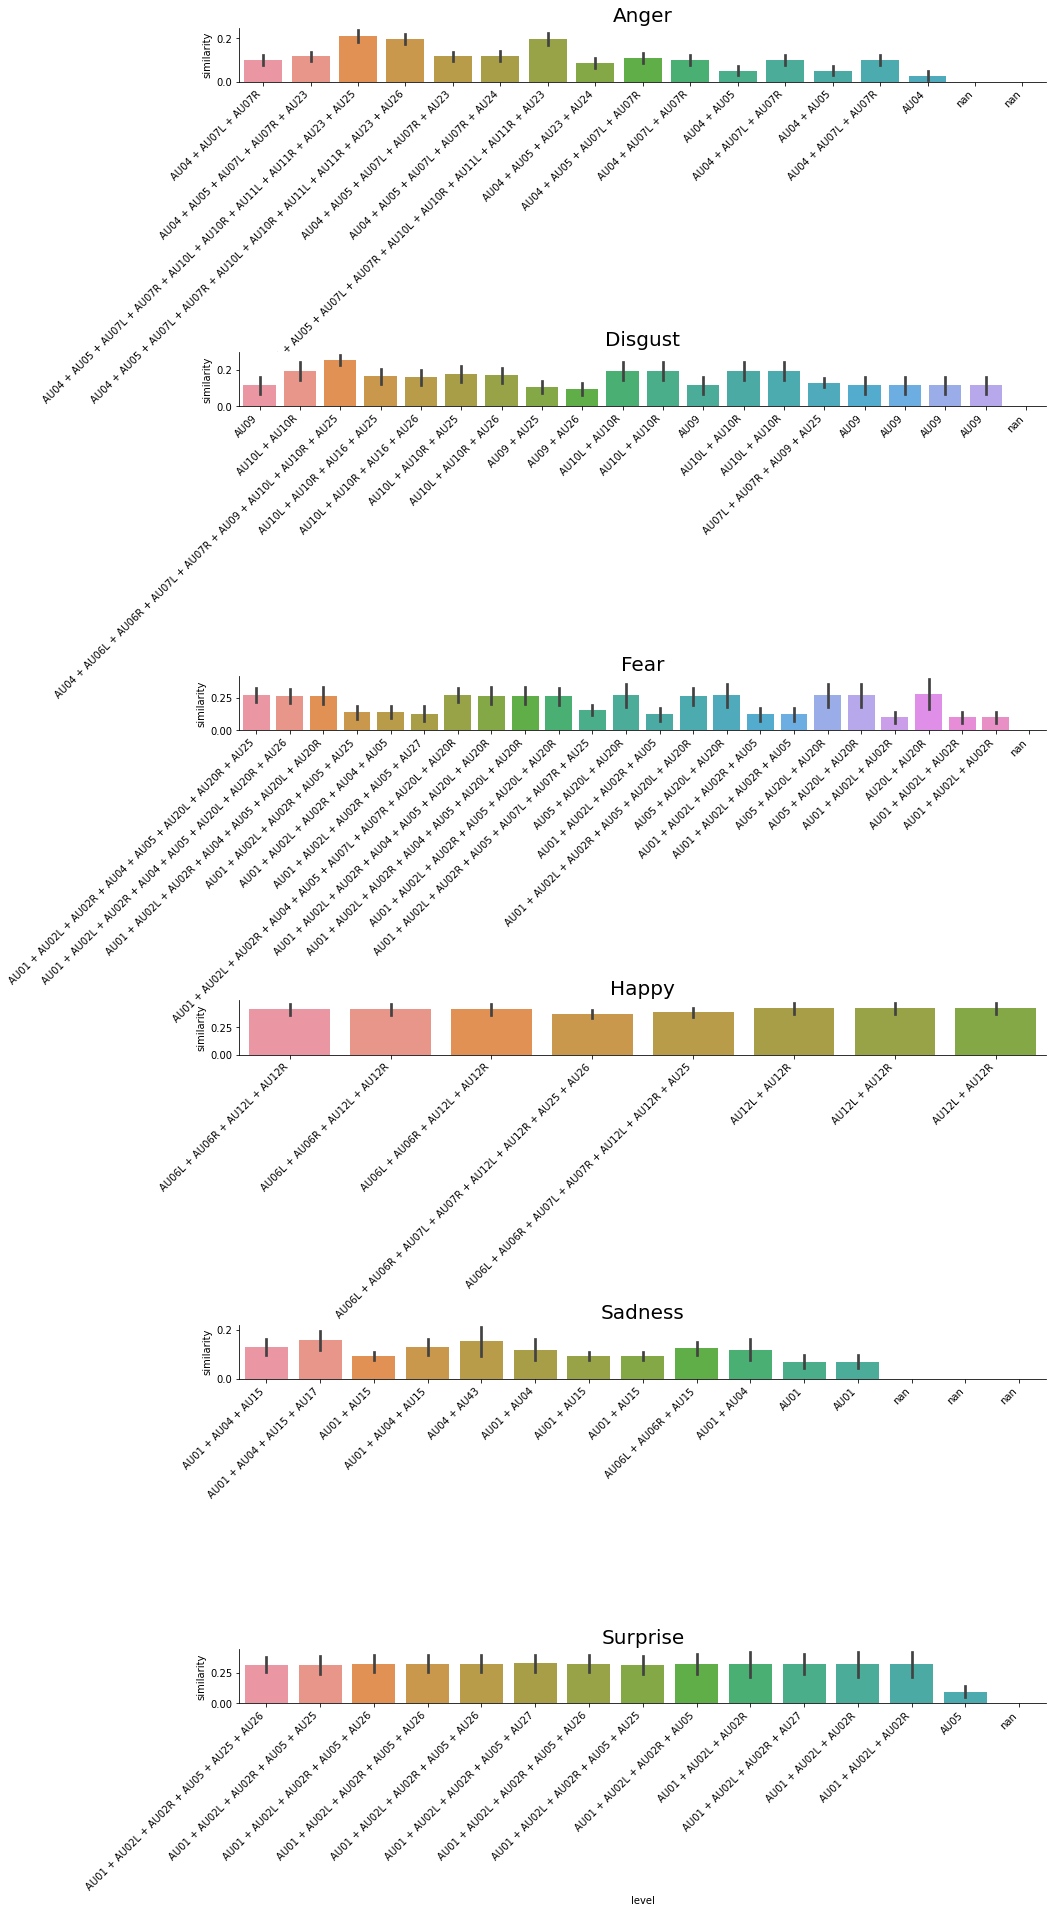

In [80]:
scores = pd.read_csv('../results/scores_hierarchical_analysis.tsv', sep='\t')
g = sns.catplot(kind='bar', x='level', y='similarity', data=scores, row='emotion',
                ci='sd', aspect=3, height=4, sharex=False, sharey=False)

emotions = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
for ax, emo in zip(g.axes, emotions):
    xticks = scores.query("emotion == @emo & sub == 1")['AUs'].to_list()
    ax[0].set_xticklabels(xticks, rotation=45, ha='right')
    ax[0].set_title(emo.capitalize(), fontsize=20)

plt.subplots_adjust(hspace = 5)